# W-net Model - Train

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
from keras.optimizers import  Adam


# Importing our w-net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import frequency_spatial_network as fsnet

# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

2022-10-18 18:55:54.727247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 18:55:54.857972: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-18 18:55:54.863081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 18:55:54.863098: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
import keras
print(keras.__version__)

print(keras.__version__)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

2.10.0
2.10.0
Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Train Set 
train_path = r"../../calgary/Train/Train/*.npy"
# train_path = r"D:\Dataset\calgary\Train_Temp\*.npy"
kspace_files_train = np.asarray(glob.glob(train_path))

# Validation set
val_path = r"../../calgary/Val/Val/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]


print(kspace_files_train[-1])
print(len(kspace_files_train))

print(kspace_files_val[-1])
print(len(kspace_files_val))

../../calgary/Train/Train/e14140s3_P52224.7.npy
25
../../calgary/Val/Val/e14378s5_P40448.7.npy
10


Undersampling: 0.82293701171875
Mask type: bool


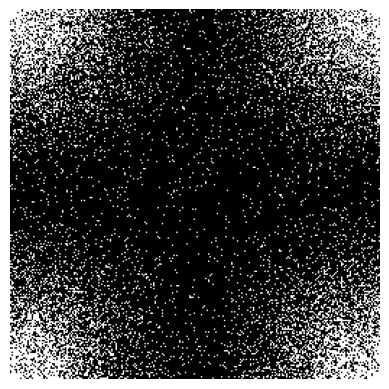

In [4]:
under_rate = '20'
imshape = (256,256)
norm = np.sqrt(imshape[0]*imshape[1])
nchannels = 2 #complex data real + imag

# undersampling patterns - uncentred k-space
var_sampling_mask = np.load("../Data/sampling_mask_" + under_rate + "perc.npy")

print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
print("Mask type:",  var_sampling_mask.dtype)
plt.figure()
plt.imshow(~var_sampling_mask,cmap = "gray")
plt.axis("off")
plt.show()

## Load Train Data

In [5]:
# Get number of samples
ntrain = 0
for ii in range(len(kspace_files_train)):
    ntrain += np.load(kspace_files_train[ii]).shape[0]

# Load train data    
rec_train = np.zeros((ntrain,imshape[0],imshape[1],2))
kspace_train = np.zeros((ntrain,imshape[0],imshape[1],2))
aux_counter = 0
for ii in range(len(kspace_files_train)):
     aux_kspace = np.load(kspace_files_train[ii])/norm
     aux = aux_kspace.shape[0]   
     aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1])
     rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
     rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
     kspace_train[aux_counter:aux_counter+aux,:,:,0] = aux_kspace[:,:,:,0]
     kspace_train[aux_counter:aux_counter+aux,:,:,1] = aux_kspace[:,:,:,1]
     aux_counter+=aux

# Shuffle training    
indexes = np.arange(rec_train.shape[0],dtype = int)
np.random.shuffle(indexes)
rec_train = rec_train[indexes]

kspace_train[:,var_sampling_mask,:] = 0 # undersample k-space

# save k-space and image domain stats
stats = np.zeros(4)
stats[0] = kspace_train.mean()
stats[1] = kspace_train.std()
aux = np.abs(rec_train[:,:,:,0] +1j*rec_train[:,:,:,1])
stats[2] = aux.mean()
stats[3] = aux.std()
np.save("../Data/stats_fs_unet_norm_" + under_rate + ".npy",stats)

print("Number of training samples", rec_train.shape[0])
kspace_train = 0 # release memory

Number of training samples 4254


## Load Validation Data

In [6]:
# Get number of samples
nval = 0
for ii in range(len(kspace_files_val)):
    nval += np.load(kspace_files_val[ii]).shape[0]

kspace_val = np.zeros((nval,imshape[0],imshape[1],nchannels))
rec_val = np.zeros((nval,imshape[0],imshape[1],1))
aux_counter = 0
for ii in range(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux = aux_kspace.shape[0]   
    kspace_val[aux_counter:aux_counter+aux] = aux_kspace
    rec_val[aux_counter:aux_counter+aux,:,:,0] = \
    np.abs(np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1]))
    aux_counter+=aux

# Undersampling kspace
kspace_val2 = kspace_val.copy()
kspace_val[:,var_sampling_mask,:] = 0
kspace_val = (kspace_val-stats[0])/stats[1]

print("Number of samples", kspace_val.shape[0])
print("Kspace under stats", kspace_val.mean(),kspace_val.std())
print("Kspace full stats", kspace_val2.mean(),kspace_val2.std())
print("Rec stats", rec_val.mean(),rec_val.std())

Number of samples 1700
Kspace under stats -1.2661701795260954e-05 0.9676880783869478
Kspace full stats 0.09448459411815592 1102.6839607341471
Rec stats 4.02626689360427 4.571199197368042


## Initialize Model

In [7]:
epochs = 1
batch_size= 16
model = fsnet.wnet(stats[0],stats[1],stats[2],stats[3],\
                                   kshape = (5,5),kshape2=(3,3))
opt = Adam(lr=1e-3,decay = 1e-7)
model.compile(loss = [fsnet.nrmse,fsnet.nrmse],optimizer=opt, loss_weights=[0.01, 0.99])

model_name = "../Models/wnet_" + under_rate + ".hdf5"
if os.path.isfile(model_name):
    model.load_weights(model_name)

print(model.summary())

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

/home/aditya/Test/venv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2022-10-18 18:57:41.514260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 18:57:41.514335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-18 18:57:41.514436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-18 18:57:41.514494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyn

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 48  2448        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 48  57648       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 2)  98          ['conv2d_20[0][0]']              
                                                                                                  
 add (Add)                      (None, 256, 256, 2)  0           ['conv2d_21[0][0]',              
                                                                  'input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 2)  0           ['add[0][0]']                    
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 1)  0           ['lambda[0][0]']                 
                                                                                                  
 lambda_4 

                                                                                                  
 conv2d_41 (Conv2D)             (None, 256, 256, 48  20784       ['conv2d_40[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_42 (Conv2D)             (None, 256, 256, 48  20784       ['conv2d_41[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_43 (Conv2D)             (None, 256, 256, 1)  49          ['conv2d_42[0][0]']              
                                                                                                  
Total params: 11,331,299
Trainable params: 11,331,299
Non-trainable params: 0
_______________________________

## Data Augmentation

(16, 256, 256, 1)


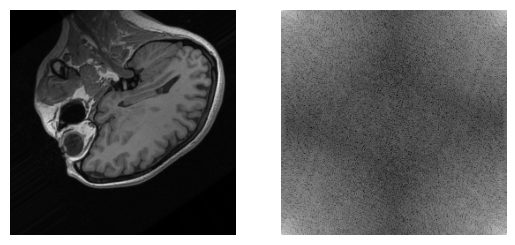

In [8]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(rec_train[:,:,:,0,np.newaxis], augment=True, seed=seed)
image_datagen2.fit(rec_train[:,:,:,1,np.newaxis], augment=True, seed=seed)

image_generator1 = image_datagen1.flow(rec_train[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(rec_train[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2,under_mask,stats):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        kspace = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        kspace2 = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        kspace2[:,:,:,0] = kspace.real
        kspace2[:,:,:,1] = kspace.imag
        kspace_under = kspace2.copy()
        kspace_under[:,var_sampling_mask,:] = 0
        kspace_under = (kspace_under-stats[0])/stats[1]
        rec = np.abs(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])[:,:,:,np.newaxis]
        yield(kspace_under, [kspace2,rec])

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,image_generator2, var_sampling_mask,stats)


# sample data augmentation
for ii in combined:
    print(ii[1][1].shape)
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[1][1][10,:,:,0],cmap = 'gray')
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(np.log(1+np.abs(ii[1][0][10,:,:,0] + 1j*ii[1][0][8,:,:,1])),cmap = 'gray')
    plt.axis("off")
    plt.show()
    break

## Train model

In [9]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=rec_train.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (kspace_val,[kspace_val2,rec_val]),
                 callbacks=[checkpoint,earlyStopping])

/tmp/ipykernel_39925/1152778846.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(combined,


266/265 [==============================] - ETA: -1s - batch: 132.5000 - size: 15.9925 - loss: 0.0571 - lambda_loss: 0.1647 - conv2d_43_loss: 0.0561

/home/aditya/Test/venv/lib/python3.8/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


265/265 [==============================] - 2484s 9s/step - batch: 132.5000 - size: 15.9925 - loss: 0.0571 - lambda_loss: 0.1647 - conv2d_43_loss: 0.0561 - val_loss: 0.0755 - val_lambda_loss: 0.1823 - val_conv2d_43_loss: 0.0744
